<a href="" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CDMPP Computing Subgroup Workshop Machine Learning Tutorial: Training a Jet Tagging with **DNN**

---
In this notebook, we perform a Jet identification task using a multiclass classifier based on a
Dense Neural Network (DNN), also called multi-layer perceptron (MLP). The problem consists on identifying a given jet as a quark, a gluon, a W, a Z, or a top,
based on set of physics-motivated high-level features.

For details on the physics problem, see https://arxiv.org/pdf/1804.06913.pdf

For details on the dataset, see Notebook1

---

In [ ]:
import os
import h5py
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Preparation of the training and validation samples

---
In order to import the dataset, we now
- clone the dataset repository (to import the data in Colab)
- load the h5 files in the data/ repository
- extract the data we need: a target and jetImage

To type shell commands, we start the command line with !

**nb, if you are running locally and you have already downloaded the datasets you can skip the cell below and, if needed, change the paths later to point to the folder with your previous download of the datasets.**

In [ ]:
! curl https://cernbox.cern.ch/s/zZDKjltAcJW0RB7/download -o Data-MLtutorial.tar.gz
! tar -xvzf Data-MLtutorial.tar.gz
! ls Data-MLtutorial/JetDataset/
! rm Data-MLtutorial.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  333M    0  333M    0     0  15.5M      0 --:--:--  0:00:21 --:--:-- 24.0M
Data-MLtutorial/
Data-MLtutorial/JetDataset/
Data-MLtutorial/JetDataset/jetImage_7_100p_0_10000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_10000_20000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_40000_50000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_50000_60000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_60000_70000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_70000_80000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_80000_90000.h5
jetImage_7_100p_0_10000.h5	jetImage_7_100p_40000_50000.h5	jetImage_7_100p_70000_80000.h5
jetImage_7_100p_10000_20000.h5	jetImage_7_100p_50000_60000.h5	jetImage_7_100p_80000_90000.h5
jetImage_7_100p_30000_40000.h5	jetImage_7_100p_60000_70000.h5


In [ ]:
target = np.array([])
features = np.array([])
# we cannot load all data on Colab. So we just take a few files
datafiles = ['Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_60000_70000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_50000_60000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_10000_20000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_0_10000.h5']
# if you are running locally, you can use the full dataset doing
# for fileIN in glob.glob("Data-MLtutorial/JetDataset/*h5"):

for fileIN in datafiles:
    print("Appending %s" %fileIN)
    f = h5py.File(fileIN)
    myFeatures = np.array(f.get("jets")[:,[12, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 52]])
    mytarget = np.array(f.get('jets')[0:,-6:-1])
    features = np.concatenate([features, myFeatures], axis=0) if features.size else myFeatures
    target = np.concatenate([target, mytarget], axis=0) if target.size else mytarget
    f.close()
print(target.shape, features.shape)

Appending Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_60000_70000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_50000_60000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_10000_20000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_0_10000.h5
(50000, 5) (50000, 16)


The dataset consists of 50000 jets, each represented by 16 features

For those who are curious, our jet-level variables we are using are:
~~~
12 - b'j_zlogz'
34 - b'j_c1_b0_mmdt'
35 - b'j_c1_b1_mmdt'
36 - b'j_c1_b2_mmdt'
37 - b'j_c2_b1_mmdt'
38 - b'j_c2_b2_mmdt'
39 - b'j_d2_b1_mmdt'
40 - b'j_d2_b2_mmdt'
41 - b'j_d2_a1_b1_mmdt'
42 - b'j_d2_a1_b2_mmdt'
43 - b'j_m2_b1_mmdt'
44 - b'j_m2_b2_mmdt'
45 - b'j_n2_b1_mmdt'
46 - b'j_n2_b2_mmdt'
48 - b'j_mass_mmdt'
52 - b'j_multiplicity'
~~~

For our first NN, we only wish to do top tagging between a top jet and a quark jet. So we will filter out all the other jets for now.


In [ ]:
# Step 1: Identify indices where the target meets the criteria (1 in the first or fifth slot)
mask = (target[:, 0] == 1) | (target[:, 4] == 1) # [:,1] is gluons (u,d,s), [:,4] is top

# Step 2: Filter features and target arrays based on the mask
filtered_features = features[mask]
filtered_target = target[mask]

# Step 3: Create the new target 'isTop' based on the criteria
# If 1 in the first slot -> isTop = 0, if 1 in the fifth slot -> isTop = 1
filtered_target = np.where(filtered_target[:, 0] == 1, 0, 1)

print(filtered_target)
print(sum(filtered_target))

[0 0 1 ... 1 1 1]
10040


We now shuffle the data, splitting them into a training and a validation dataset with 2:1 ratio

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(filtered_features, filtered_target, test_size=0.33)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)


(13469, 16) (6634, 16) (13469,) (6634,)


# DNN model building

There are two main Pythonic packages to perform ML: **tensorflow/keras** & **PyTorch**.

In this tutorial we will focus on using TensorFlow/keras

In [ ]:
# keras imports
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics

In [ ]:
input_shape = X_train.shape[1]
dropoutRate = 0.25

# Challenge 0: Lecture Example (5 mins)

We will build our simple network from the lecture

In [ ]:
####
inputArray = Input(shape=(input_shape,))
#
x = Dense(2, activation='relu')(inputArray)
x = Dropout(dropoutRate)(x)
#
output = Dense(1, activation='sigmoid')(x)


# output = Dense(1, activation='sigmoid')(x)
####
model = Model(inputs=inputArray, outputs=output)

The Dropout layer in Keras randomly sets input units to 0 with a frequency rate at each step during training, helping prevent overfitting.

We can then compile our model. We are using the "adam" optimiser to perform our gradient descent, see https://arxiv.org/abs/1412.6980

In [ ]:
model.compile(loss='BCE', optimizer='adam')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense (Dense)               (None, 2)                 34        
                                                                 
 dropout (Dropout)           (None, 2)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 3         
                                                                 
Total params: 37 (148.00 Byte)
Trainable params: 37 (148.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


We now train the model with these settings:

- the **batch size** is a hyperparameter of gradient descent that controls the number of training samples to work through before the model internal parameters are updated
    - batch size = 1 results in fast computation but noisy training that is slow to converge
    - batch size = dataset size results in slow computation but faster convergence)

- the **number of epochs** controls the number of complete passes through the full training dataset -- at each epoch gradients are computed for each of the mini batches and model internal parameters are updated.


In [ ]:
batch_size = 128
n_epochs = 25

# train
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, y_val))

Epoch 1/25
106/106 - 2s - loss: 0.7801 - val_loss: 0.7113 - 2s/epoch - 16ms/step
Epoch 2/25
106/106 - 0s - loss: 0.7022 - val_loss: 0.6960 - 386ms/epoch - 4ms/step
Epoch 3/25
106/106 - 0s - loss: 0.6948 - val_loss: 0.6936 - 398ms/epoch - 4ms/step
Epoch 4/25
106/106 - 0s - loss: 0.6929 - val_loss: 0.6922 - 247ms/epoch - 2ms/step
Epoch 5/25
106/106 - 0s - loss: 0.6888 - val_loss: 0.6830 - 234ms/epoch - 2ms/step
Epoch 6/25
106/106 - 0s - loss: 0.6507 - val_loss: 0.5900 - 317ms/epoch - 3ms/step
Epoch 7/25
106/106 - 0s - loss: 0.5659 - val_loss: 0.5132 - 234ms/epoch - 2ms/step
Epoch 8/25
106/106 - 0s - loss: 0.5381 - val_loss: 0.4961 - 232ms/epoch - 2ms/step
Epoch 9/25
106/106 - 0s - loss: 0.5286 - val_loss: 0.4886 - 236ms/epoch - 2ms/step
Epoch 10/25
106/106 - 0s - loss: 0.5301 - val_loss: 0.4796 - 232ms/epoch - 2ms/step
Epoch 11/25
106/106 - 0s - loss: 0.5239 - val_loss: 0.4725 - 231ms/epoch - 2ms/step
Epoch 12/25
106/106 - 0s - loss: 0.5241 - val_loss: 0.4714 - 318ms/epoch - 3ms/step
Epo

Note: Running "fit" on a model that has already been fitted, with continue to train the same model. But it will not save its previous history... be careful!

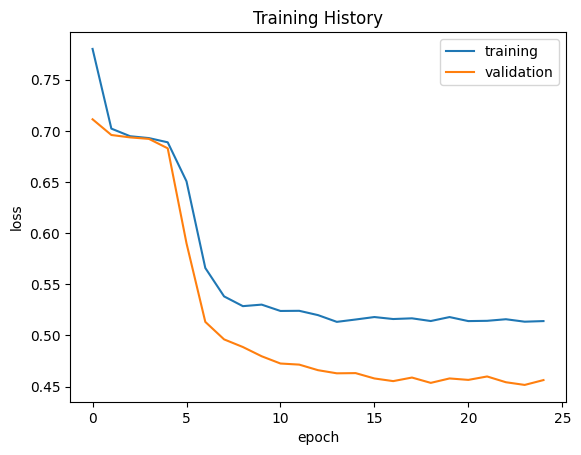

In [ ]:
# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
# plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

## Evaluating

To evaluate we will build a ROC Curve, and calculate the auc.

208/208 [==============================] - 0s 1ms/step


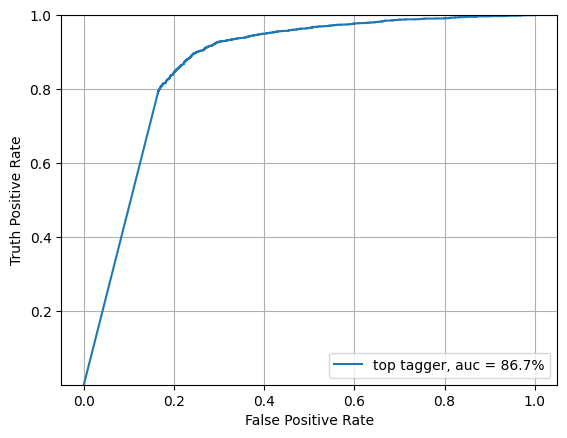

In [ ]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
predict_val = model.predict(X_val)
df = pd.DataFrame()
fpr = {}
tpr = {}
auc1 = {}
plt.figure()
label = 'top'

df[label] = y_val
df[label + '_pred'] = predict_val

fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

auc1[label] = auc(fpr[label], tpr[label])

plt.plot(fpr[label],tpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))
# plt.semilogy()
plt.xlabel("False Positive Rate")
plt.ylabel("Truth Positive Rate")
plt.ylim(0.000001,1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()

Fun little note: Why would you sometimes see that ``val_loss`` converges to `` 0.6930`` and predict with ``auc ~ 50%``?

# Optional Challenge 0: Changing Learning Rate

By default, the learning rate is 1e-3. However, we might want to change it. One way of doing this is to import the Adam optimiser, and set the learning rate directly. i.e.

```
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0001)  # Example learning rate

# Compile the model with the optimizer
model.compile(optimizer=optimizer, loss='BCE')
```

# Challenge 1: Improving our Neural Network (20 mins)

We have a relatively simple model, being a single layer with only 2 nodes. Lets see how we can make it more complex.


## Model Building

*Hint*: Copy the model from above and then
1. Add 3 more hidden layers, so there is a total of 4 hidden layers and have the layer sizes of (80,40,20,10).
   - You can do this by copying the ``x =`` lines, and replace the ``inputArray``  with ``x``
2. Add a "Dropout" layer between the hidden layers


In [ ]:
### SOLUTION ####


## Training

*Hint*: Copy the code from above

In [ ]:
### SOLUTION ###


In [ ]:
# plot training history


## Evaluating

*Hint*: Copy the code from above

In [ ]:
### SOLUTION ###


Hopefully it improved? Maybe it didnt... Play around with hyperparameters such as learning rate, batch size and hidden layer size to see if you can get an improvement...


# Optional Challenge: Adding Callbacks

At the moment, we have no extra conditions on our training. What if we are running our network for 100 epochs but we get no improvement after the first 10? It would be a waste of compute time (and our time) to continue to train.

**callbacks** are algorithms used to optimize the training (full list [here](https://keras.io/api/callbacks/)):
    - *EarlyStopping*: stop training when a monitored metric (`monitor`) has stopped improving in the last N epochs (`patience`)
    - *ReduceLROnPlateau*: reduce learning rate when a metric (`monitor`) has stopped improving in the last N epochs (`patience`)
    - *TerminateOnNaN*: terminates training when a NaN loss is encountered

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

To use, just add "callbacks" to the .fit(...) like

~~~
history = model.fit(<other stuff>,
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])
~~~

Try adding callbacks to the model... you might need to re-make a new model first!

In [ ]:
### SOLUTION ###


# Challenge 2: Make it predict on all of the different categories  (25mins)

In our dataset we have access to 5 different types of jet, what if we want to build a classification model to classify between all of these?

In [ ]:
for fileIN in datafiles:
    print("Appending %s" %fileIN)
    f = h5py.File(fileIN)
    myFeatures = np.array(f.get("jets")[:,[12, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 52]])
    mytarget = np.array(f.get('jets')[0:,-6:-1])
    features = np.concatenate([features, myFeatures], axis=0) if features.size else myFeatures
    target = np.concatenate([target, mytarget], axis=0) if target.size else mytarget
    f.close()
print(target.shape, features.shape)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.33)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

## One-hot-encoding

One hot encoding converts categorical variables into binary vectors representing each category's presence (1) or absence (0).

Example:
~~~
[1,0,0,0,0], # quark
[0,1,0,0,0], # W
[0,0,1,0,0], # Z
[0,0,0,1,0], # gluon
[0,0,0,0,1], # top
~~~

## Model Building...

*Hint:* Copy your model from the previous example and change
1. The output: 1  -> 5
2. The loss function: "BCE"  -> "categorical_crossentropy"


In [ ]:
#### SOLUTION #####


## Training:

Hint: Copy the code from before, it should work!

In [ ]:
### SOLUTION ###


In [ ]:
# plot training history


## Evaluating:

*Hint*:  Copy the ROC curve code here
1. Loop over the labels container
2. Isolate the prediction for each particle type
3. Calculate the ROC curve/auc for particle
4. Plot on the same axis


In [ ]:
### SOLUTION ###


Once you have done this and if there is extra time, play around with the hyperparameters to try and get better auc

# Optional Challenge 2: Confusion Matrix

A confusion matrix is another way to evaluate the performance of a classification model. It is a matrix which compares the truth value to the predicted value. See [link](https://www.analyticsvidhya.com/blog/2020/04/confusion-matrix-machine-learning/#:~:text=A%20confusion%20matrix%20is%20a%20performance%20evaluation%20tool%20in%20machine,false%20positives%2C%20and%20false%20negatives.)

This might make the result more understandable. For example, if we know there is confusion between two particle types (i.e. $W$'s and $Z$'s) we might have more of an insight on where our model breaks down. We can use the functions from:

```
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns #to plot
import tensorflow as tf
```

One thing you will have to do is convert the one-hot-encoding to a single value. The suggestion is to use ``np.argmax(y_val)`` and ``np.argmax(predict_val)`` , and sub these into  `` tf.math.confusion_matrix()``

In [ ]:
### SOLUTION ###


# Challenge 3: Regression instead of classification (30mins)

It is common to instead use NN's to predict on continous value rather than a simple classification. We will do some regression on the jet mass

## Data preperation:


*Hint*: Copy the code for getting the features and targets. Change the target to be the jet mass (48th element of the jet features). To make sure you have the mass, plot the target! Make sure you remove the jet mass from the feature list! It might also be useful to use the ``train_test_split`` function to keep track of the truth particle type by adding another arguement. i.e
```
X_train, X_val, y_train, y_val, ohe_train, ohe_val = train_test_split(features, target,ohe, test_size=0.33)
```

In [ ]:
### SOLUTION ###


## Model Building

*Hint*: Copy the code model from before.

1. Change the output back to 1.
2. Change the loss function to be "MSE" (or any other regression loss function)
3. Change the final layers activation fuction to be "linear" instead of sigmoid

In [ ]:
### SOLUTION ###


## Training:



In [ ]:
### SOLUTION ###


In [ ]:
# plot training history


## Evaluating:
*Hint*: Since we are no longer performing classification, a ROC curve does not make sense to use. We willl be using the response, which mathematically is
$$
Response = \frac{M_{prediction}}{M_{truth}}
$$
In an ideal case, this should be exactly 1. If response is larger than 1, it means we are over predicting, and conversely if the reponse is less than 1, we are under predicting

To evaluate:
1. Copy the evaluating code from before
2. Calculate the reponse
3. Plot the response

4. BONUS: Look at the reponse per particle type, to see if there are any trends


If it is unable to train, mess around with the hyperparameters!

In [ ]:
### SOLUTION ###


In [ ]:
### BONUS ###


# Conclusion

Well done for making it to the end of the notebook! See if you can improve the regression!

Other things you could look at (if you havent already)

1. Normalisation of the data
2. Removing some of the data
3. Principle Component Analysis
4. K-fold Validation
5. Classification and Regression at the same time


This material was heavily inspired by the [SLAC Summer Institute Jet Notebooks](https://github.com/makagan/SSI_Projects/tree/main/jet_notebooks)

For those who want more complicated tutorials, there are some there